In [52]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading both the training and testing dataset:

In [53]:
CW_DATASET_PATH = "CW_dataset"

def load_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")
    x_test_all_path = os.path.join(dataset_path, "x_test_all.csv")
    y_test_all_path = os.path.join(dataset_path, "y_test_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)
    x_test_all = pd.read_csv(x_test_all_path)
    y_test_all = pd.read_csv(y_test_all_path)

    return x_train_all, y_train_all,x_test_all,y_test_all

In [54]:
x_train, y_train,x_test, y_test = load_data()

In [55]:
x_train_normalized, x_test_normalized=np.array(x_train)/255, np.array(x_test)/255
x_train_reshaped = x_train_normalized.reshape((x_train_normalized.shape[0], 48, 48, 1))
x_test_reshaped = x_test_normalized.reshape((x_test_normalized.shape[0], 48, 48, 1))

In [56]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score,roc_auc_score
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve, auc

def calculate_metrics_and_mean(X_train, y_train, y_pred, model):
    report = classification_report(y_train, y_pred, output_dict=True,zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3].drop(columns='support')
    cm = confusion_matrix(y_train, y_pred)
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    tp_fp_rate_df = pd.DataFrame({'TPR': tp_rate, 'FPR': fp_rate}, index=range(len(tp_rate)))
    specificity = []
    unique_labels = np.unique(y_train)
    try:
        for i in range(len(unique_labels)):
            true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            total_negative = np.sum(cm) - np.sum(cm[i, :])
            specificity.append(true_negative / total_negative)
        specificity_df = pd.DataFrame({'specificity': specificity}, index=unique_labels)
    except:
        specificity_df = pd.DataFrame({'specificity': np.nan}, index=unique_labels)
    try:
        sensitivity = recall_score(y_train, y_pred, average=None)
        sensitivity_df = pd.DataFrame({'sensitivity': sensitivity}, index=unique_labels)
    except:
        sensitivity_df = pd.DataFrame({'sensitivity': np.nan}, index=unique_labels)

    result_df = pd.concat([report_df.reset_index().drop(columns='index'),
                           tp_fp_rate_df.reset_index().drop(columns='index'),
                           specificity_df.reset_index().drop(columns='index'),
                           sensitivity_df.reset_index().drop(columns='index')], axis=1)
    
    try:
        probabilities=model.predict_proba(X_train)
        aucs= []
        for i in range(len(unique_labels)):
            fpr_dt, tpr_dt, _ = roc_curve((y_test == unique_labels[i]).astype(int), probabilities[:, i])
            roc_auc_dt = auc(fpr_dt, tpr_dt)
            aucs.append(roc_auc_dt)
    except:
        aucs = 0
    auc_df = pd.DataFrame({'AUC': aucs}, index=unique_labels)
    
    accuracy = accuracy_score(y_train, y_pred)
    accuracy_df = pd.DataFrame({'accuracy': [accuracy]})
    
    try:
        cross_val_scores = cross_val_score(model, X_train, y_train, cv=10)
    except :
        try:
            cross_val_scores = cross_val_predict(model, X_train, y_train, cv=10)
        except:
            cross_val_scores = [0]

    cross_val_mean = np.mean(cross_val_scores)
    cross_val_std = np.std(cross_val_scores)
    cross_val_df = pd.DataFrame({'CV mean': [cross_val_mean], 'CV std': [cross_val_std]})

    result_df = pd.concat([result_df, auc_df, accuracy_df, cross_val_df], axis=1)
    mean_values = pd.DataFrame(result_df.mean()).transpose()
    mean_values.index = ['mean']
    result_df = pd.concat([result_df, mean_values])
    
    return result_df

https://www.tensorflow.org/tutorials/images/cnn

https://colab.research.google.com/drive/1uWZQ-lzAk5308YVjMW5XaZcS_3zmGSgN?usp=sharing

In [57]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn(input_shape=input_shape, num_classes=10, dense_units=64, learning_rate=0.001, loss='sparse_categorical_crossentropy',
               kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    # pooling input layer
    model.add(layers.MaxPooling2D((2, 2)))
    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


In [58]:
def plotHistory(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')

In [59]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
import pandas as pd

results_df=pd.DataFrame()

def cross_validate_and_evaluate(x_train, y_train, x_test, y_test,
                                 model,name='Model', epochs=10, batch_size=64):
    history = model.fit(x_train, y_train, epochs=epochs,
                         batch_size=batch_size, validation_data=(x_test_reshaped, y_test), verbose=0)
    
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    test_accuracy = accuracy_score(model.predict(x_test), y_test)
    train_accuracy = accuracy_score(model.predict(x_train), y_train)
    cv_accuracy = cross_val_score(model, x_train, y_train, cv=kf, scoring='accuracy', verbose=0).mean()

    results_dict = {'Model': name,
                    'CV10_Mean_Accuracy': cv_accuracy,
                    'Train_accuracy': train_accuracy,
                    'Test_accuracy': test_accuracy,
                    }
    global results_df 
    results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)
    return results_dict, history


C:\Users\ishaq\AppData\Local\Temp\ipykernel_14180\270069022.py:9: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


31/31 [==============================] - 0s 3ms/step


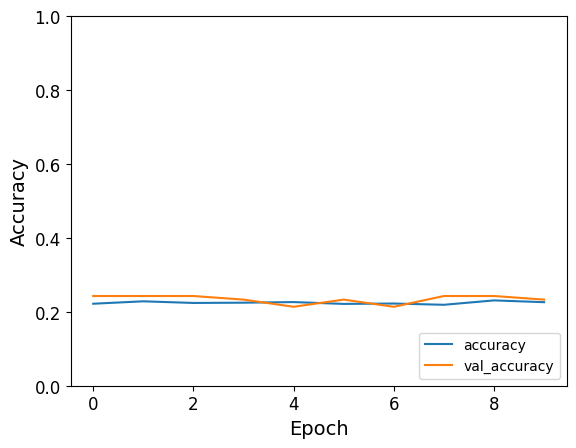

In [60]:
from keras.wrappers.scikit_learn import KerasClassifier

num_classes=10
epochs=10
batch_size=64
kernel=(3, 3)
strides=(2, 2)
input_shape=x_train_reshaped.shape[1:]
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.1)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                    'M1 LR 0.1',epochs,batch_size)
plotHistory(history)

C:\Users\ishaq\AppData\Local\Temp\ipykernel_14180\2507795216.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


31/31 [==============================] - 0s 2ms/step


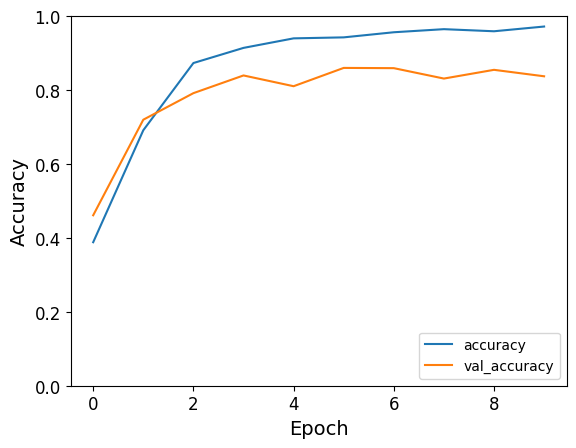

In [61]:
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape, 
                        num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.01)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                    'M1 LR 0.01',epochs,batch_size)
plotHistory(history)

C:\Users\ishaq\AppData\Local\Temp\ipykernel_14180\2504390988.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


31/31 [==============================] - 0s 3ms/step


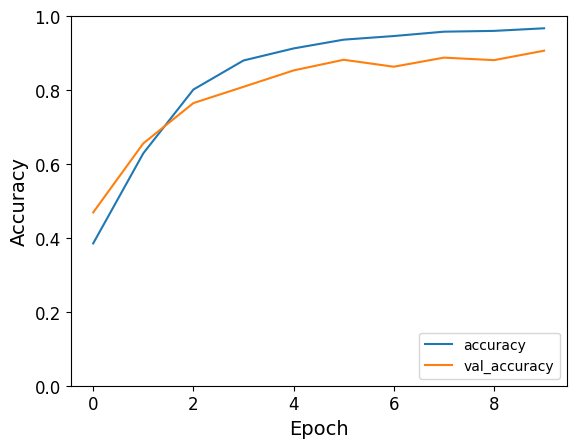

In [62]:
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                    'M1 LR 0.001',epochs,batch_size)
plotHistory(history)

C:\Users\ishaq\AppData\Local\Temp\ipykernel_14180\3029777442.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


31/31 [==============================] - 0s 3ms/step


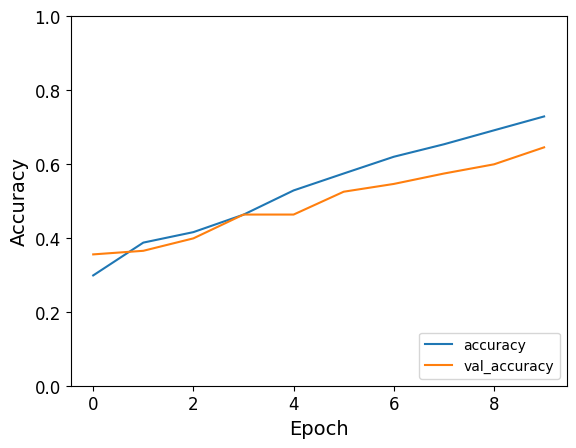

In [63]:
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape, 
                        num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.0001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                    'M1 LR 0.0001',epochs,batch_size)
plotHistory(history)

C:\Users\ishaq\AppData\Local\Temp\ipykernel_14180\103253170.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


31/31 [==============================] - 0s 3ms/step


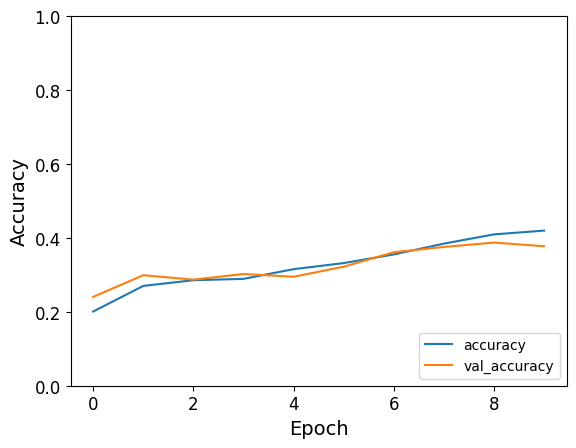

In [64]:
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.00001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model, 
                                                  'M1 LR 0.00001',epochs,batch_size)
plotHistory(history)

In [65]:
results_df

,Model,CV10_Mean_Accuracy,Train_accuracy,Test_accuracy
0,M1 LR 0.1,0.225697,0.229102,0.233010
1,M1 LR 0.01,0.737049,0.956037,0.837217
2,M1 LR 0.001,0.618679,0.978225,0.906472
3,M1 LR 0.0001,0.387410,0.750877,0.644984
4,M1 LR 0.00001,0.256140,0.417337,0.377346


In [66]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn_ex(input_shape=input_shape, num_classes=10, dense_units=64,
                   learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))
    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


C:\Users\ishaq\AppData\Local\Temp\ipykernel_14180\4150922143.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex, input_shape=input_shape,


31/31 [==============================] - 0s 3ms/step


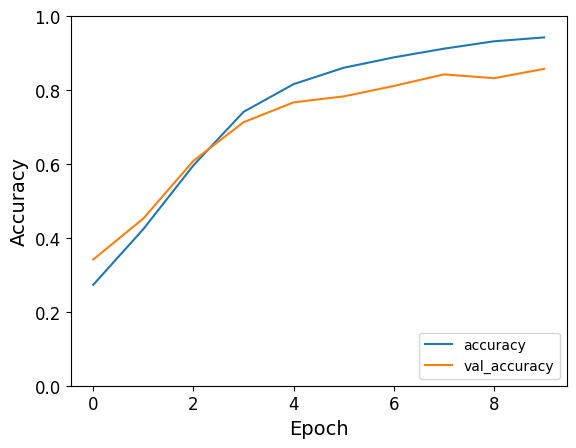

In [67]:
# best LR so far 0.001

model = KerasClassifier(build_fn=create_cnn_ex, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model, 
                                                  'M2 LR 0.001',epochs,batch_size)
plotHistory(history)

In [68]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn_ex2(input_shape=input_shape, num_classes=10, dense_units=64,
                    learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))

    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


C:\Users\ishaq\AppData\Local\Temp\ipykernel_14180\2165110188.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, input_shape=input_shape,


31/31 [==============================] - 0s 3ms/step


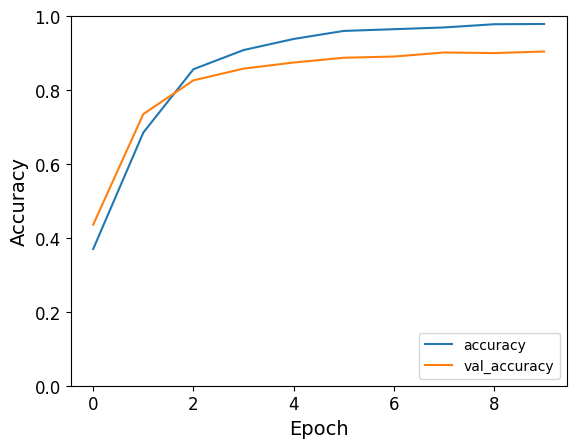

In [69]:
# best LR so far 0.001

model = KerasClassifier(build_fn=create_cnn_ex2, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model, 
                                                  'M3 LR 0.001',epochs,batch_size)
plotHistory(history)

https://adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasClassifier.html#scikeras.wrappers.KerasClassifier


In [70]:
results_df

,Model,CV10_Mean_Accuracy,Train_accuracy,Test_accuracy
0,M1 LR 0.1,0.225697,0.229102,0.233010
1,M1 LR 0.01,0.737049,0.956037,0.837217
2,M1 LR 0.001,0.618679,0.978225,0.906472
3,M1 LR 0.0001,0.387410,0.750877,0.644984
4,M1 LR 0.00001,0.256140,0.417337,0.377346
5,M2 LR 0.001,0.397420,0.942105,0.857282
6,M3 LR 0.001,0.642828,0.985243,0.904207


In [71]:
from sklearn.model_selection import ParameterGrid



param_grid = {
    # 'batch_size': [32, 64, 128],
    'epochs': [1],
    'learning_rate': [0.01],
    'kernel': [(3, 3), (5, 5)],
    'strides': [(1, 1), (2, 2)],
    # 'filters': [32, 64, 128],
    'dense_units': [64, 128],
}
i=0
best_accuracy = 0
best_params = {}
for params in ParameterGrid(param_grid):
    print(i)
    model = KerasClassifier(build_fn=create_cnn_ex2, **params)
    results_dict, history = cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model, 
                                                  f'M3 CVsearch {i}',epochs,batch_size)
    if results_dict['Test_accuracy'] > best_accuracy:
        best_accuracy = results_dict['Test_accuracy'] 
        best_params = params
    i+=1

0


C:\Users\ishaq\AppData\Local\Temp\ipykernel_14180\2306949602.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


31/31 [==============================] - 0s 10ms/step
1


C:\Users\ishaq\AppData\Local\Temp\ipykernel_14180\2306949602.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


31/31 [==============================] - 0s 3ms/step
2


C:\Users\ishaq\AppData\Local\Temp\ipykernel_14180\2306949602.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


31/31 [==============================] - 1s 18ms/step
3


C:\Users\ishaq\AppData\Local\Temp\ipykernel_14180\2306949602.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


31/31 [==============================] - 0s 3ms/step
4


C:\Users\ishaq\AppData\Local\Temp\ipykernel_14180\2306949602.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


31/31 [==============================] - 0s 11ms/step
5


C:\Users\ishaq\AppData\Local\Temp\ipykernel_14180\2306949602.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


31/31 [==============================] - 0s 3ms/step
6


C:\Users\ishaq\AppData\Local\Temp\ipykernel_14180\2306949602.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


31/31 [==============================] - 1s 17ms/step
7


C:\Users\ishaq\AppData\Local\Temp\ipykernel_14180\2306949602.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **params)


31/31 [==============================] - 0s 3ms/step


In [72]:
results_df

,Model,CV10_Mean_Accuracy,Train_accuracy,Test_accuracy
0,M1 LR 0.1,0.225697,0.229102,0.233010
1,M1 LR 0.01,0.737049,0.956037,0.837217
2,M1 LR 0.001,0.618679,0.978225,0.906472
3,M1 LR 0.0001,0.387410,0.750877,0.644984
4,M1 LR 0.00001,0.256140,0.417337,0.377346
5,M2 LR 0.001,0.397420,0.942105,0.857282
6,M3 LR 0.001,0.642828,0.985243,0.904207
7,M3 CVsearch 0,0.618060,0.992982,0.921036
8,M3 CVsearch 1,0.650258,0.953251,0.878641
9,M3 CVsearch 2,0.601651,0.232198,0.242718


In [73]:
best_params.pop('epochs',None)

1

In [74]:
best_params

{'dense_units': 64, 'kernel': (3, 3), 'learning_rate': 0.01, 'strides': (1, 1)}

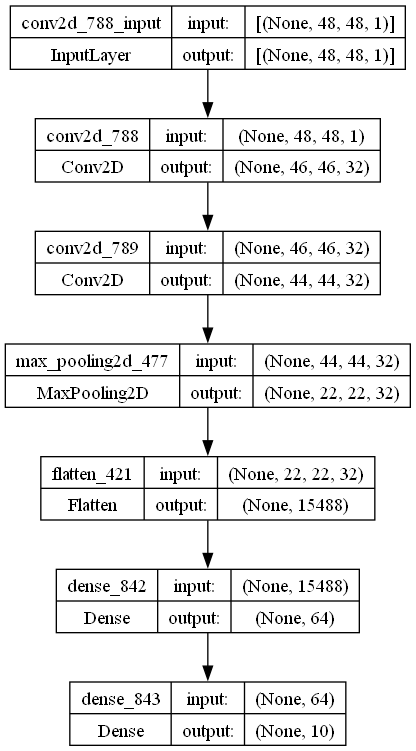

In [75]:
from tensorflow import keras

model = create_cnn_ex2(**best_params)
keras.utils.plot_model(model , show_shapes=True)

C:\Users\ishaq\AppData\Local\Temp\ipykernel_14180\84844361.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex, **best_params)


31/31 [==============================] - 0s 11ms/step


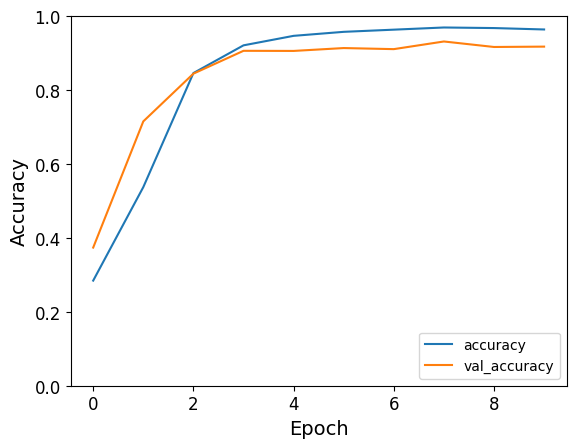

In [76]:
model = KerasClassifier(build_fn=create_cnn_ex, **best_params)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model, 
                                                  'M3 Best 0.001',epochs=epochs,batch_size=batch_size)
plotHistory(history)


In [77]:
results_df

,Model,CV10_Mean_Accuracy,Train_accuracy,Test_accuracy
0,M1 LR 0.1,0.225697,0.229102,0.233010
1,M1 LR 0.01,0.737049,0.956037,0.837217
2,M1 LR 0.001,0.618679,0.978225,0.906472
3,M1 LR 0.0001,0.387410,0.750877,0.644984
4,M1 LR 0.00001,0.256140,0.417337,0.377346
5,M2 LR 0.001,0.397420,0.942105,0.857282
6,M3 LR 0.001,0.642828,0.985243,0.904207
7,M3 CVsearch 0,0.618060,0.992982,0.921036
8,M3 CVsearch 1,0.650258,0.953251,0.878641
9,M3 CVsearch 2,0.601651,0.232198,0.242718


In [ ]:
y_pred=model.predict(x_train_reshaped)
calculate_metrics_and_mean(x_train_reshaped,y_train,y_pred,model)